<a href="https://colab.research.google.com/github/DajeanArcila/biblioteca_pandas/blob/main/Series_temporais_com_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from statsmodels.tsa.arima.model import ARIMA

In [5]:
!pip install scipy

In [6]:
!pip install pmdarima

In [7]:
from pmdarima.arima import auto_arima

In [8]:
# vamos importar a base de produção de energia elétrica
df = pd.read_excel('energy.xlsx', index_col='DATE', parse_dates=True)
df.head()

,energy
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [9]:
# quantas linhas e colunas?
df.shape

(408, 1)

In [10]:
# Estatística descritiva
df.describe()

,energy
count,408.000000
mean,88.062232
std,15.168540
min,54.616500
25%,76.499750
50%,88.940450
75%,99.733200
max,126.362600


In [11]:
# Quando começam e terminam os dados?
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

In [12]:
df.columns = ['producao']

<Axes: xlabel='DATE'>

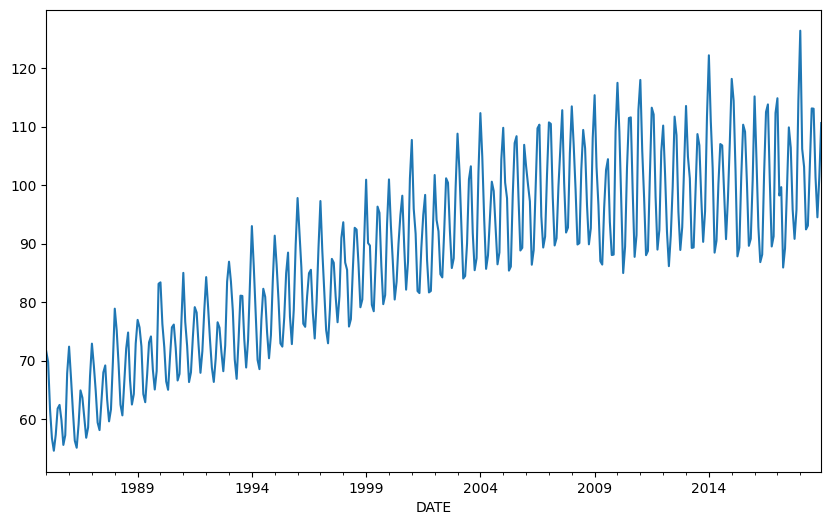

In [13]:
# Vamos dar uma olhada no gráfico de consumo x anos
df['producao'].plot(figsize=(10,6))


<Figure size 800x600 with 0 Axes>

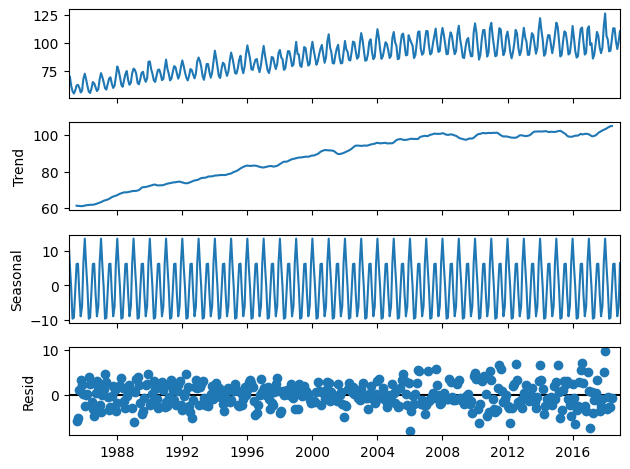

In [14]:
# Primeiro, vamos decompor a série pra avaliar tendência
# Sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df)

fig = plt.figure(figsize=(8, 6))
fig = resultado.plot()

In [15]:
# Teste de estacionariedade.
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['producao'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-2.252399047046594
p-valor:0.18777984601967806


In [16]:
# Teste de estacionariedade.
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['producao'].diff().dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-7.450892277526341
p-valor:5.67456995585561e-11


In [17]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True,
                           m=6,
                           D=1,
                           start_P=1,
                           start_Q=1,
                           max_P=2,
                           max_Q=2,
                           information_criterion='aic',
                           trace=True,
                           error_action='ignore',
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1968.148, Time=0.81 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2494.965, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=2053.701, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2128.799, Time=0.49 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2064.883, Time=1.11 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=1.17 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1928.298, Time=3.19 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=2.88 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=1868.200, Time=5.00 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=1866.400, Time=3.86 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=2014.153, Time=2.31 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=1916.488, Time=4.19 sec
 ARIMA(1,1,0)(1,1,2)[6]             : AIC=1936.850, Time=2.65 sec
 ARIMA(2,1,1)(1,1,2)[6]             : AIC=1868.120, Time=4.75 sec
 ARIMA(1,1,2)(1,1,2)[6]             : AIC=1

In [18]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX
# (versão do arima com parametros para sazonalidade)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df,order=(1,1,1),  seasonal_order=(1, 1, 2, 6))
resultado_sarimax = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
# resultados do modelo SARIMAX(2,1,2)
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                               producao   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 6)   Log Likelihood                -927.200
Date:                                Sun, 09 Jun 2024   AIC                           1866.400
Time:                                        17:18:38   BIC                           1890.364
Sample:                                    01-01-1985   HQIC                          1875.889
                                         - 12-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5125      0.042     12.156      0.000       0.430       0.595
ma.L1         -0.9601      0.017    -56.250      0.000      -0.994      -0.927
ar.S.L6       -0.9973      0.003   -350.055      0.000      -1.003      -0.992
ma.S.L6        0.1026      0.037      2.775      0.006       0.030       0.175
ma.S.L12      -0.7748      0.035    -22.180      0.000      -0.843      -0.706
sigma2         5.6413      0.322     17.544      0.000       5.011       6.272
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                29.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [21]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(115.1447404570401, 124.45517675290846)

In [22]:
predicao_media[0]

119.79995860497428

In [23]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

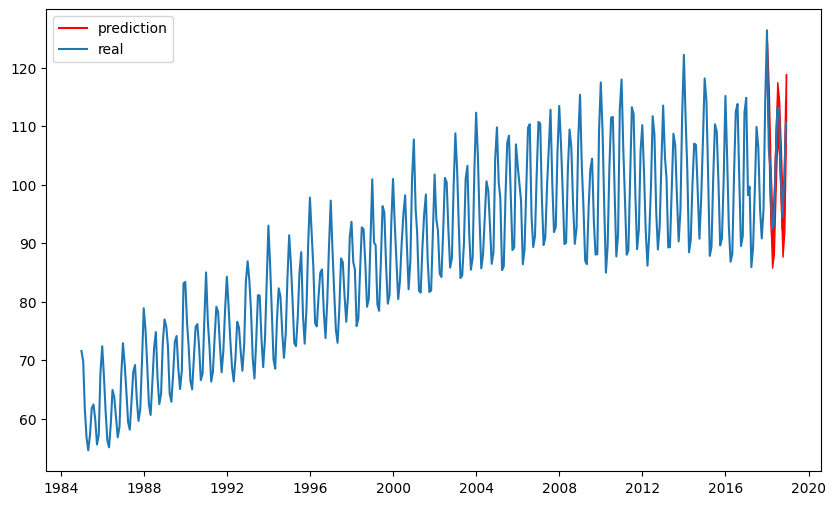

In [24]:

plt.figure(figsize=(10,6))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, df.values, label='real')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(df[-12:].values,predicao_media.values))
print(rmse_sarima)

3.4262786953866433


##FORECAST COM ARIMA

In [26]:
# Forecast pra 12 values

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [27]:

intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]

(91.38813005236821, 103.10930985132882)

In [28]:
forecast_medio[10]

97.24871995184851

In [29]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

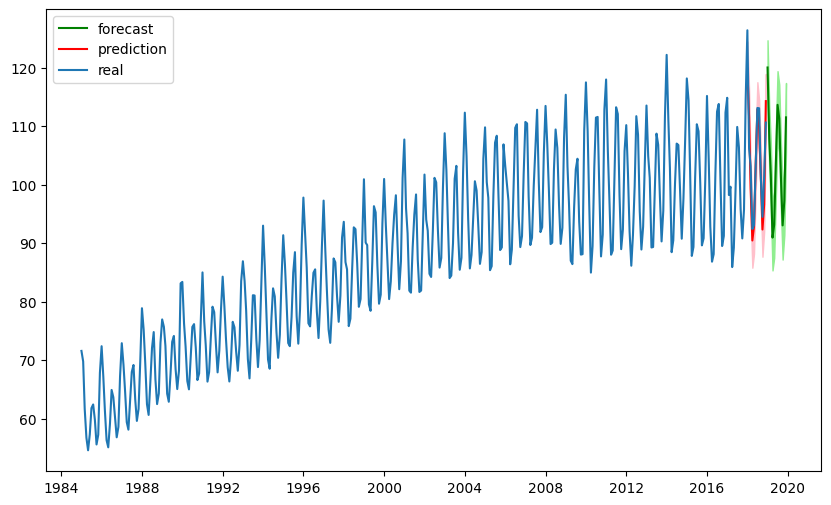

In [30]:

dates=np.asarray(df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates,df.values, label='real')
plt.legend(loc='upper left')
plt.show()

In [31]:
from xgboost import XGBRegressor

In [32]:
treino = df.loc[df.index < "2016-12-31"]
validacao = df.loc[df.index > "2016-12-31"]

treino.shape, validacao.shape

((384, 1), (24, 1))

In [33]:
treino.head()

,producao
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [34]:
treino["target"] = treino["producao"].shift(-1)
treino.head()

<ipython-input-34-1f6b0df3518f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino["target"] = treino["producao"].shift(-1)


,producao,target
DATE,,
1985-01-01,71.5920,69.7870
1985-02-01,69.7870,61.6790
1985-03-01,61.6790,56.7479
1985-04-01,56.7479,54.6165
1985-05-01,54.6165,57.3509


In [35]:
treino.dropna(inplace=True)

<ipython-input-35-b8dd0b7f87ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino.dropna(inplace=True)


In [36]:
validacao["target"] = validacao["producao"].shift(-1)
validacao.head()

<ipython-input-36-66ef9ff7cc40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao["target"] = validacao["producao"].shift(-1)


,producao,target
DATE,,
2017-01-01,114.8282,98.2191
2017-02-01,98.2191,99.6408
2017-03-01,99.6408,85.9106
2017-04-01,85.9106,89.2053
2017-05-01,89.2053,99.1945


In [37]:
validacao.dropna(inplace=True)

<ipython-input-37-bda36cca96cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao.dropna(inplace=True)


In [38]:
x_treino = treino.loc[:, ["producao"]].values
y_treino = treino.loc[:, ["target"]].values
x_validacao = validacao.loc[:, ["producao"]].values
y_validacao = validacao.loc[:, ["target"]].values

In [39]:
modelo_xgba = XGBRegressor()
modelo_xgba.fit(x_treino, y_treino)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
validacao.iloc[0]

producao    114.8282
target       98.2191
Name: 2017-01-01 00:00:00, dtype: float64

In [41]:
predicao = modelo_xgba.predict(x_validacao)
predicao

array([103.05468 ,  89.6212  , 108.89758 ,  79.16283 ,  93.78335 ,
        99.628296, 101.583725, 110.23003 , 106.858765,  98.68999 ,
       106.858765, 103.05468 , 110.27728 ,  97.96312 , 103.55588 ,
        96.872536,  86.97877 , 105.77548 , 114.146774, 114.146774,
       111.32476 ,  97.687325, 111.32476 ], dtype=float32)

In [42]:
validacao["pred"] = predicao
validacao.head()

<ipython-input-42-59e209950550>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao["pred"] = predicao


,producao,target,pred
DATE,,,
2017-01-01,114.8282,98.2191,103.054680
2017-02-01,98.2191,99.6408,89.621201
2017-03-01,99.6408,85.9106,108.897583
2017-04-01,85.9106,89.2053,79.162827
2017-05-01,89.2053,99.1945,93.783348


In [43]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(x_validacao, predicao)

6.86671642747962